# **AIM - Training a Variational Autoencoder (VAE) Using TensorFlow**

### **AAI EXP 3 - Yash Ashok Shirsath**

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 63s 123ms/step - loss: 0.0956 - val_loss: 0.0677
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 107ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 107ms/step - loss: 0.0675 - val_loss: 0.0675
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 105ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - loss: 0.0672 - val_loss: 0.0675
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 112ms/step - loss: 0.0672 - val_loss: 0.0675
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 114ms/step - loss: 0.0673 - val_loss: 0.0675
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 110ms/step - loss: 0.0673 - val_loss: 0.0676
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step - loss: 0.0674 - val_loss: 0.0675
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 108ms/step - 

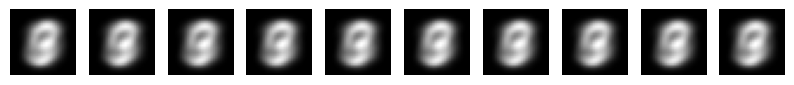

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

latent_dim = 2  # Dimension of the latent space
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

input_shape = (28, 28, 1)
inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, outputs, name="decoder")

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))
random_latent_vectors = np.random.normal(size=(10, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

fig, axes = plt.subplots(1, 10, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.show()
